In [1]:
using ITensors
using Plots
using KrylovKit
using LinearAlgebra
using MKL
using ProgressMeter
using Measures

In [2]:
ITensors.disable_warn_order()

mutable struct RydbergObserver <: AbstractObserver
    energy_tol::Float64
    last_energy::Float64

    RydbergObserver(energy_tol=0.0) = new(energy_tol, 1000.0)
end

function ITensors.checkdone!(o::RydbergObserver; kwargs...)
    sw = kwargs[:sweep]
    energy = kwargs[:energy]
    if abs(energy - o.last_energy) / abs(energy) < o.energy_tol
        # early stopping
        return true
    end
    # if sw % 50 == 0
    #     err = abs(energy-o.last_energy)/abs(energy)
    #     println("Sweep $sw, Energy Diff $err")
    # end
    o.last_energy = energy
    return false
end

function ITensors.measure!(o::RydbergObserver; kwargs...)
    energy = kwargs[:energy]
    sweep = kwargs[:sweep]
    bond = kwargs[:bond]
    outputlevel = kwargs[:outputlevel]

    # if outputlevel > 0
    #     println("Sweep $sweep at bond $bond, the energy is $energy")
    # end
end

In [34]:
# assume k = 6
function blockade_radius(rabi_f)
    C6 = 1 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    return (C6 / rabi_f)^(1 / 6)
end

function kagome_distance(i, j, k, l)
    if k == i
        return j - l
    end

    if (k - i) % 2 == 0
        return sqrt((j + 1 - l)^2 + (sqrt(3) * (i - k) / 2)^2)
    end

    return sqrt((j - l + 0.5)^2 + ((i - k) * sqrt(3) / 2)^2)
end

function square_distance(i, j, k, l)
    return sqrt((j - l)^2 + (k - i)^2)
end

function interaction_strength(i, j, k, l, geometry)
    # C6 = 2 * pi * 275 * 10^9 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    C6 = 1
    lattice_spacing = 1 # lattice constant (micrometers)
    distance = 0
    if geometry == "kagome"
        distance = kagome_distance(i, j, k, l)
    elseif geometry == "square"
        distance = square_distance(i, j, k, l)
    end

    return (C6 / distance * lattice_spacing)^6
end

function kagome_interactions(site, i, j, N1, N2)
    os = OpSum()

    for k = 1:i
        for l = 1:j-1
            if k % 2 == 1 && l % 2 == 0
                continue
            end
            site2 = (k - 1) * N1 + l
            os += interaction_strength(i, j, k, l, "kagome"), "ProjUp", site2, "ProjUp", site
        end
    end
    return os
end

# returns i, j
function snake_site(site, N1)
    if ((site - 1) ÷ N1 + 1) % 2 == 0
        return (site - 1) ÷ N1 + 1, (site - 1) % N1 + 1
    end
    return (site - 1) ÷ N1 + 1, site % N1 + 1
end

function square_interactions(site, N1)
    os = OpSum()

    i, j = snake_site(site, N1)

    for site2 = 1:site-1
        k, l = snake_site(site2, N1)
        os += interaction_strength(i, j, k, l, "square"), "ProjUp", site2, "ProjUp", site
    end

    # for k = 1:i
    #     for l = 1:j-1
    #         site2 = (k - 1) * N1 + l
    #         snake_ind = l
    #         if k % 2 == 1
    #             snake_ind = N1 - l + 1
    #         end
    #         os += interaction_strength(i, j, k, snake_ind, "square"), "ProjUp", site2, "ProjUp", site
    #     end
    # end
    return os
end

function rydberg_hamiltonian(geometry, N1, N2, rabi_f, delt)
    os = OpSum()

    if geometry == "kagome"
        for i = 1:N2
            for j = 1:N1
                if i % 2 == 0 && j % 2 == 0
                    continue
                end
                site = (i - 1) * N1 + j
                os += 0.5 * rabi_f, "X", site
                os -= delt, "ProjUp", site
                os += kagome_interactions(site, i, j, N1, N2)
            end
        end
    end

    if geometry == "square"
        for site = 1:N1*N2
            os += 0.5 * rabi_f, "X", site
            os -= delt, "ProjUp", site
            os += square_interactions(site, N1)
        end

        # for i = 1:N2
        #     for j = 1:N1
        #         site = (i - 1) * N1 + j
        #         os += 0.5 * rabi_f, "X", site
        #         os -= delt, "ProjUp", site

        #         snake_ind = j
        #         if i % 2 == 1
        #             snake_ind = N1 - j + 1
        #         end
        #         os += square_interactions(site, i, snake_ind, N1, N2)
        #     end
        # end
    end

    # println(combiner(sites)*contract(H))
    # @show H
    # display_mpo_elements(os)

    # println(os)

    return os
end

function display_mpo_elements(H)
    N = length(H)
    for n = 1:N
        println("Tensor $n of the MPO:")
        println(H[n])
        println("------")
    end
end

function bipartite_entropy(psi)
    b = Int(ceil(length(psi) / 2))
    # from ITensor docs
    ITensors.orthogonalize!(psi, b)
    U, S, V = svd(psi[b], (linkind(psi, b - 1), siteind(psi, b)))
    SvN = 0.0
    for n in 1:dim(S, 1)
        p = S[n, n]^2
        SvN -= p * log2(p)
    end
    return SvN
end

function ground_state(geometry, N1, N2, psi0, sites, rabi_f, delt, ed_, krylov_dim=3)
    H = MPO(rydberg_hamiltonian(geometry, N1, N2, rabi_f, delt), sites)

    nsweeps = 100
    # maxdim = [100, 100, 200, 200, 400]
    maxdim = 10000
    # maxdim = fill(100,nsweeps)
    cutoff = 1E-13

    etol = 1E-20

    noise = 1E9

    psi = randomMPS(sites)
    energy = 0
    obs = RydbergObserver(etol)
    if ed_ == true
        energy, psi = ed(H, psi0, sites, krylov_dim)
    end
    if ed_ == false
        energy, psi = dmrg(H, psi0; nsweeps=nsweeps, maxdim=maxdim, cutoff=cutoff, noise=noise, outputlevel=0, println=false)
    end

    
    # eigen(H, )
    H2 = inner(H,psi,H,psi)
    E = inner(psi',H,psi)
    var = H2-E^2
    # println(E)
    println("Variance $var")
    # println()

    # combin = combiner(sites)
    # println(combin * contract(psi))
    # println(energy)
    entropy__ = bipartite_entropy(psi)
    return entropy__, energy, psi
end

function first_excitation(geometry, N1, N2, psi0, ground_psi, sites, rabi_f, delt)
    H = MPO(rydberg_hamiltonian(geometry, N1, N2, rabi_f, delt), sites)

    nsweeps = 1500
    # maxdim = [100, 100, 100, 100, 100, 100, 200, 500, 1000]
    maxdim = 400
    cutoff = fill(1E-10, nsweeps)
    weight = 1E6

    etol = 1E-10

    noise = 1E6

    obs = RydbergObserver(etol)
    energy, excited_psi = dmrg(H, [ground_psi], psi0; nsweeps, maxdim, cutoff, weight=weight, noise=noise, observer=obs, outputlevel=0, println=false)

    # println(inner(excited_psi, ground_psi))
    return energy, excited_psi
end

function avg_rydberg(psi)
    avgr = 0
    for i = 1:length(psi)
        avgr += expect(psi, "ProjUp"; sites=i)
    end
    return avgr / length(psi)
end

function measure_mps(psi)
    measurement = []
    for i = 1:length(psi)
        push!(measurement, round(expect(psi, "ProjUp"; sites=i), digits=2))
    end
    return measurement
end

function ed(H, psi0, sites, krylov_dim)
    vals, vecs, info = @time eigsolve(
        contract(H), contract(psi0), 1, :SR; ishermitian=true, tol=1e-20, krylovdim=krylov_dim, eager=true
    )
    return vals[1], MPS(vecs[1], sites)
end

function dominant_eigenstate(psi, width, height)
    c = contract(psi)
    # Hitensor = ITensor(1.)
    # for i = 1:N
    #     Hitensor *= H[i]
    # end

    A = Array(c,siteinds(psi))
    max_i = 1
    for i = 1:length(A)
        if A[i] > A[max_i]
            max_i = i
        end
    end

    # Convert the number to binary using the base conversion function
    binary_str = string(max_i, base=2)
    
    # Pad the binary string with leading zeros to fit the width x height
    binary_str = lpad(binary_str, width * height, '0')
    
    # Create the 2D array
    eigenstate = zeros(Int, height, width)
    
    for site = 1:length(psi)
        i, j = snake_site(site, width)
        eigenstate[i, j] = abs(parse(Int, binary_str[site]) - 1)
    end

    return heatmap(
        eigenstate,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="x",
        ylabel="y",
        colorbar_title="Rydberg Excitation",
        axis=false
    )
end

function focus(geometry, N1, N2, x, y, psi0, sites)
    C6 = 1
    a = 1

    rabi_freq = C6 / ((a * y)^6)
    delta = x * rabi_freq

    println(rabi_freq)
    println(delta)
    println(N1)
    println(N2)

    entropy_, energy, gs = ground_state(geometry, N1, N2, psi0, sites, rabi_freq, delta, false, 30)
    # ground_state(geometry, N1, N2, psi0, sites, rabi_freq, delta, ed_, krylov_dim)
    excitation = zeros(Float64, N2, N1)

    for i = 1:N1*N2
        k, l = snake_site(i, N1)
        excitation[k, l] = expect(gs, "ProjUp"; sites=i)
    end

    return entropy_, energy, gs, heatmap(
        excitation,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="x",
        ylabel="y",
        title="R_b/a=$y, Δ/Ω=$x",
        colorbar_title="Rydberg Excitation",
        axis=false
    )
end

focus (generic function with 1 method)

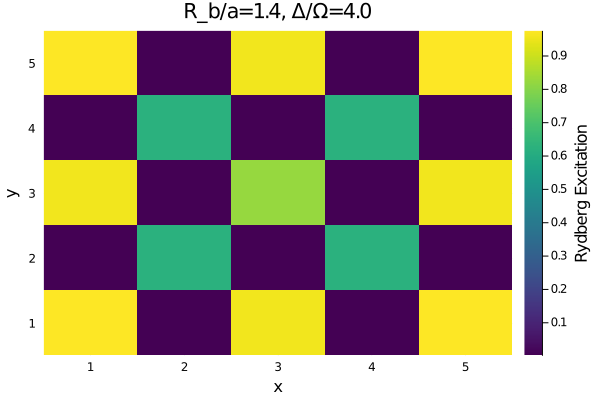

In [157]:
# snake mps starting at bottom right
geometry = "square"
N1 = 5 # x
N2 = 5 # y
sites = siteinds("Qubit", N1 * N2)
psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4.0, 1.4, psi0, sites)

Sweep 50, Energy Diff 0.00121937447356236


Sweep 100, Energy Diff 0.0002963615145494027


Sweep 150, Energy Diff 0.00011077995864314318


Sweep 200, Energy Diff 4.679802261479426e-5


Sweep 250, Energy Diff 1.7268416579376376e-5


Sweep 300, Energy Diff 1.2293839323965207e-5


Sweep 350, Energy Diff 7.373266051873014e-6


Sweep 400, Energy Diff 5.462793162029144e-6


Sweep 450, Energy Diff 4.44111494592652e-6


Sweep 500, Energy Diff 3.830251007732048e-6


Sweep 550, Energy Diff 2.9493517578463794e-6


Sweep 600, Energy Diff 2.525055521424751e-6


Sweep 650, Energy Diff 2.139930797747691e-6


Sweep 700, Energy Diff 1.8194955943009275e-6


Sweep 750, Energy Diff 1.4931957676478376e-6


Sweep 800, Energy Diff 1.245808526589384e-6


Sweep 850, Energy Diff 1.0742561402951518e-6


Sweep 900, Energy Diff 8.937271160488883e-7


Sweep 950, Energy Diff 7.822308966606929e-7


Sweep 1000, Energy Diff 6.711316330221419e-7


Sweep 1050, Energy Diff 5.653744211489925e-7


Sweep 1100, Energy Diff 5.053331680983758e-7


Sweep 1150, Energy Diff 4.277895859924767e-7


Sweep 1200, Energy Diff 3.6090905220051406e-7


Sweep 1250, Energy Diff 3.0852919154373745e-7


Sweep 1300, Energy Diff 2.9202196354465025e-7


Sweep 1350, Energy Diff 2.2327339011791112e-7


Sweep 1400, Energy Diff 2.0814164182177708e-7


Sweep 1450, Energy Diff 1.8910724371806451e-7


Sweep 1500, Energy Diff 1.3827109850198753e-7


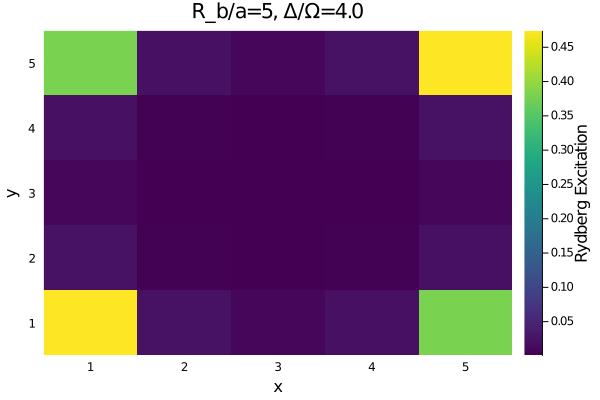

In [158]:
# snake mps starting at bottom left, 1500 sweeps
geometry = "square"
N1 = 5 # x
N2 = 5 # y
sites = siteinds("Qubit", N1 * N2)
psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4.0, 5, psi0, sites)

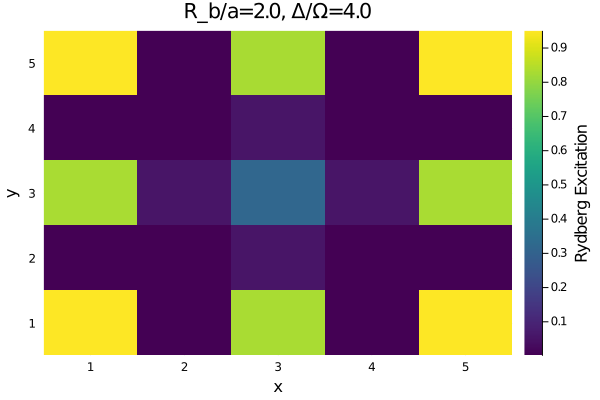

In [159]:
# snake mps starting at bottom left
geometry = "square"
N1 = 5 # x
N2 = 5 # y
sites = siteinds("Qubit", N1 * N2)
psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4.0, 2.0, psi0, sites)

Sweep 50, Energy Diff 1.212242992725766e-7


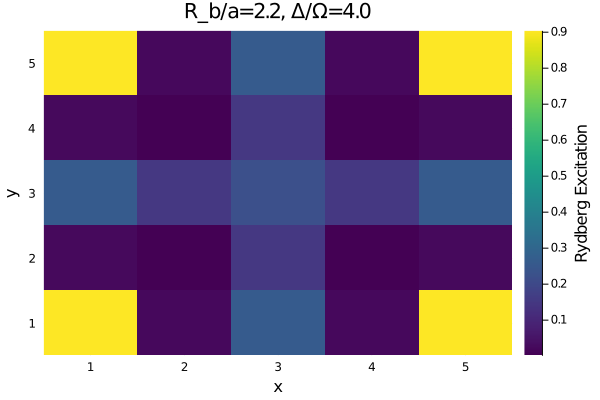

In [166]:
# snake mps starting at bottom left
geometry = "square"
N1 = 5 # x
N2 = 5 # y
sites = siteinds("Qubit", N1 * N2)
psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4.0, 2.2, psi0, sites)

Sweep 50, Energy Diff 1.4187260725733752e-6


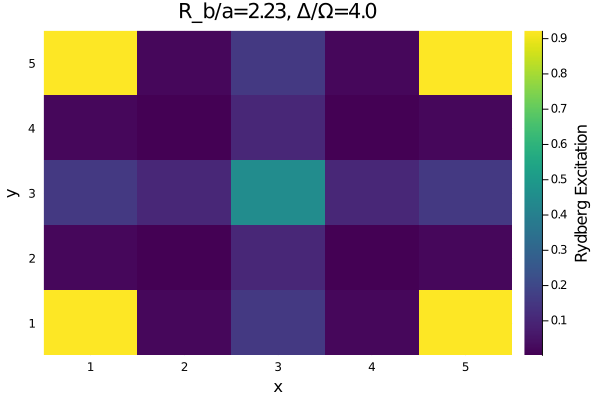

In [167]:
# snake mps starting at bottom left
geometry = "square"
N1 = 5 # x
N2 = 5 # y
sites = siteinds("Qubit", N1 * N2)
psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4.0, 2.23, psi0, sites)

Sweep 50, Energy Diff 1.1252572763616389e-6


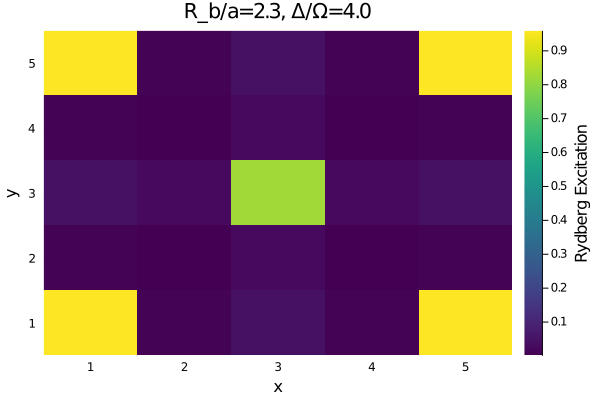

In [168]:
# snake mps starting at bottom left
geometry = "square"
N1 = 5 # x
N2 = 5 # y
sites = siteinds("Qubit", N1 * N2)
psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4.0, 2.3, psi0, sites)

In [10]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
sites = siteinds("Qubit", N1 * N2)
psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 1.5, psi0, sites)

(0.020833443578269724, -1.9706755309689123, MPS
[1] ((dim=2|id=344|"Qubit,Site,n=1"), (dim=2|id=346|"Link,l=1"))
[2] ((dim=2|id=420|"Qubit,Site,n=2"), (dim=2|id=346|"Link,l=1"), (dim=4|id=309|"Link,l=2"))
[3] ((dim=2|id=461|"Qubit,Site,n=3"), (dim=4|id=309|"Link,l=2"), (dim=8|id=215|"Link,l=3"))
[4] ((dim=2|id=235|"Qubit,Site,n=4"), (dim=8|id=215|"Link,l=3"), (dim=10|id=440|"Link,l=4"))
[5] ((dim=2|id=332|"Qubit,Site,n=5"), (dim=10|id=440|"Link,l=4"), (dim=13|id=703|"Link,l=5"))
[6] ((dim=2|id=354|"Qubit,Site,n=6"), (dim=13|id=703|"Link,l=5"), (dim=13|id=961|"Link,l=6"))
[7] ((dim=2|id=201|"Qubit,Site,n=7"), (dim=13|id=961|"Link,l=6"), (dim=16|id=668|"Link,l=7"))
[8] ((dim=2|id=718|"Qubit,Site,n=8"), (dim=14|id=462|"Link,l=8"), (dim=16|id=668|"Link,l=7"))
[9] ((dim=2|id=904|"Qubit,Site,n=9"), (dim=15|id=98|"Link,l=9"), (dim=14|id=462|"Link,l=8"))
[10] ((dim=2|id=239|"Qubit,Site,n=10"), (dim=13|id=550|"Link,l=10"), (dim=15|id=98|"Link,l=9"))
[11] ((dim=2|id=410|"Qubit,Site,n=11"), (dim=

In [35]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 1.05, psi0, sites)[4]

0.7462153966366275
2.98486158654651
2
8
Variance 6.59383658785373e-12


<!DOCTYPE html>
 
 
 Plots.jl

In [36]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 1.1, psi0, sites)[4]

0.5644739300537772
2.257895720215109
2
8
Variance 2.5579538487363607e-12


<!DOCTYPE html>
 
 
 Plots.jl

In [37]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 1.15, psi0, sites)[4]

0.43232759591155645
1.7293103836462258
2
8
Variance 3.524291969370097e-12


<!DOCTYPE html>
 
 
 Plots.jl

In [38]:
# plotlyjs()
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 1.2, psi0, sites)[4]

0.3348979766803842
1.3395919067215367
2
8
Variance 4.021671884402167e-12


<!DOCTYPE html>
 
 
 Plots.jl

In [39]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 1.3, psi0, sites)[4]

0.2071762110330033
0.8287048441320132
2
8
Variance 1.3358203432289883e-12


<!DOCTYPE html>
 
 
 Plots.jl

In [40]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 1.4, psi0, sites)[4]

0.13281030862990764
0.5312412345196306
2
8
Variance 1.7994494783124537e-12


<!DOCTYPE html>
 
 
 Plots.jl

In [41]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 1.5, psi0, sites)[4]

0.0877914951989026
0.3511659807956104
2
8
Variance 1.2159162565694714e-12


<!DOCTYPE html>
 
 
 Plots.jl

In [42]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 1.55, psi0, sites)[4]

0.07211237696263705
0.2884495078505482
2
8
Variance 1.7850165789923267e-11


<!DOCTYPE html>
 
 
 Plots.jl

In [43]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 1.6, psi0, sites)[4]

0.059604644775390604
0.23841857910156242
2
8
Variance 2.4970006062829952e-9


<!DOCTYPE html>
 
 
 Plots.jl

In [49]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 1.8, psi0, sites)[4]

0.029401194111858132
0.11760477644743253
2
8
Variance 5.580506889923953e-10


<!DOCTYPE html>
 
 
 Plots.jl

In [44]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 2.0, psi0, sites)[4]

0.015625
0.0625
2
8
Variance 1.923366344663835e-8


<!DOCTYPE html>
 
 
 Plots.jl

In [52]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 2.2, psi0, sites)[4]

0.008819905157090269
0.035279620628361076
2
8
Variance 2.9372671038474518e-8


<!DOCTYPE html>
 
 
 Plots.jl

In [45]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 2.5, psi0, sites)[4]

0.004096
0.016384
2
8
Variance 1.0673475087574422e-7


<!DOCTYPE html>
 
 
 Plots.jl

In [46]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 2.7, psi0, sites)[4]

0.002581174791713196
0.010324699166852785
2
8
Variance 2.189713386537874e-7


<!DOCTYPE html>
 
 
 Plots.jl

In [47]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 3, psi0, sites)[4]

0.0013717421124828531
0.0054869684499314125
2
8
Variance 2.446272567410072e-7


<!DOCTYPE html>
 
 
 Plots.jl

Sweep 50, Energy Diff 2.3288209084505702e-5


Sweep 100, Energy Diff 1.4844934047258631e-6


Sweep 150, Energy Diff 3.978211242954901e-7


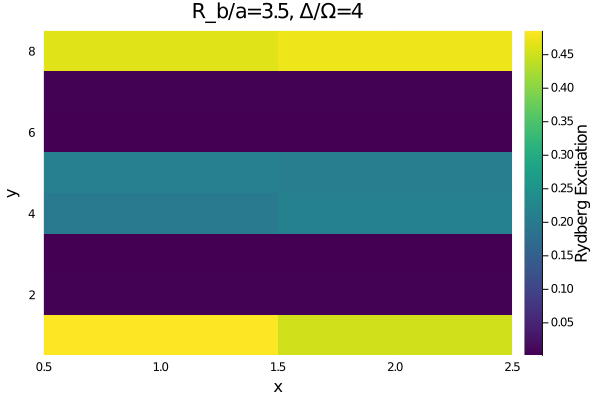

In [186]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
sites = siteinds("Qubit", N1 * N2)
psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 3.5, psi0, sites)

Sweep 50, Energy Diff 0.0001426437505431622


Sweep 100, Energy Diff 8.801766930964991e-6


Sweep 150, Energy Diff 2.3557499536653e-6


Sweep 200, Energy Diff 8.203349254097737e-7


Sweep 250, Energy Diff 2.880073978096675e-7


Sweep 300, Energy Diff 1.303437733745863e-7


Sweep 350, Energy Diff 6.750451581379713e-8


Sweep 400, Energy Diff 3.76153190734174e-8


Sweep 450, Energy Diff 2.1897140805283007e-8


Sweep 500, Energy Diff 1.3150902539768328e-8


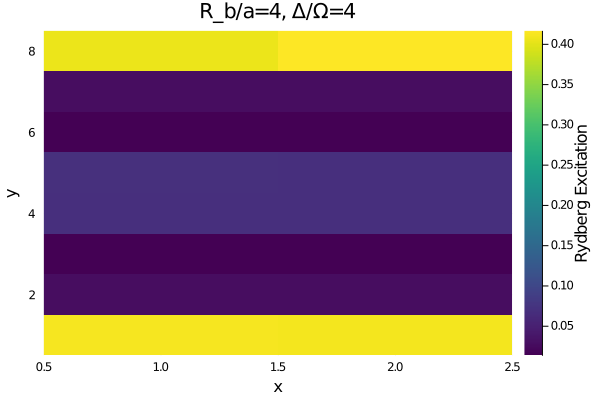

In [187]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

focus(geometry, N1, N2, 4, 4, psi0, sites)

Entropy: 0.0073457103244183135, Energy: -2.7150954396244895


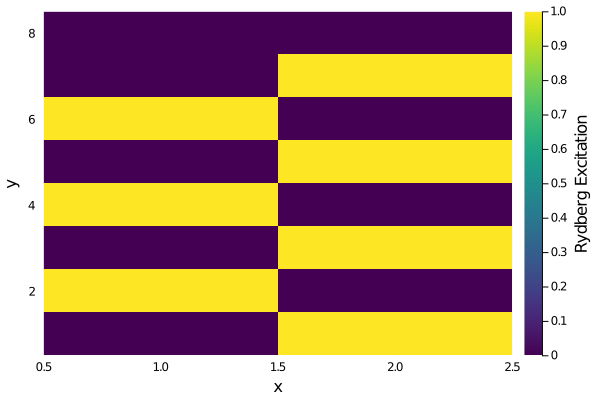

In [248]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
sites = siteinds("Qubit", N1 * N2)
psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

entropy, energy, gs, map_ = focus(geometry, N1, N2, 4.0, 1.4, psi0, sites)
println("Entropy: $entropy, Energy: $energy")
dominant_eigenstate(gs, N1, N2)

Sweep 50, Energy Diff 2.0012158795228948e-7


Sweep 100, Energy Diff 2.436051432906907e-10


Entropy: 1.109054569369857, Energy: -1.2741691361545904


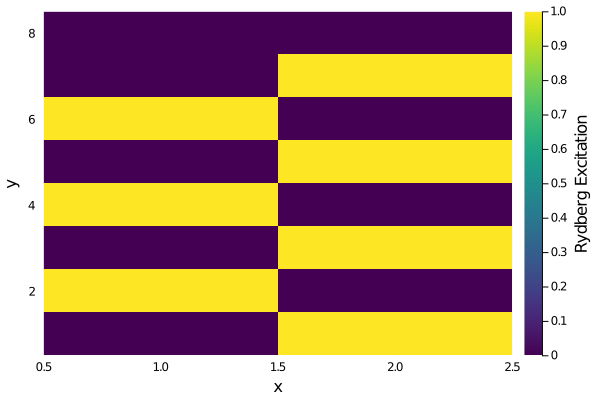

In [243]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
sites = siteinds("Qubit", N1 * N2)
psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

entropy, energy, gs, map_ = focus(geometry, N1, N2, 3.8, 1.523, psi0, sites)
println("Entropy: $entropy, Energy: $energy")
dominant_eigenstate(gs, N1, N2)

Sweep 50, Energy Diff 5.554867652776964e-8


Sweep 100, Energy Diff 5.130537405127925e-8


Sweep 150, Energy Diff 5.4928623024811194e-8


Sweep 200, Energy Diff 4.765358809662568e-8


Sweep 250, Energy Diff 3.735005316230085e-8


Sweep 300, Energy Diff 3.160408081223447e-8


Sweep 350, Energy Diff 1.904369860984737e-8


Sweep 400, Energy Diff 1.327437881304893e-8


Sweep 450, Energy Diff 1.0552876505082772e-8


Sweep 500, Energy Diff 7.223890532503088e-9


Sweep 550, Energy Diff 4.14238667290768e-9


Sweep 600, Energy Diff 2.4078457353756635e-9


Sweep 650, Energy Diff 1.9508696152699594e-9


Sweep 700, Energy Diff 8.157790689363628e-10


Sweep 750, Energy Diff 5.408585200947634e-10


Sweep 800, Energy Diff 3.75246515740278e-10


Sweep 850, Energy Diff 2.5211886755112966e-10


Sweep 900, Energy Diff 1.4774933935468604e-10


Entropy: 1.0971400049404085, Energy: -1.4029870359232435


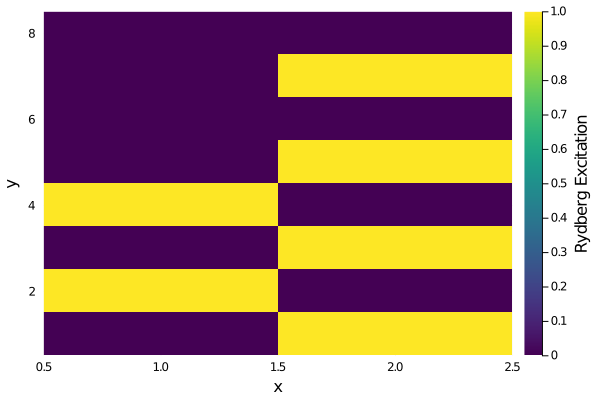

In [238]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
sites = siteinds("Qubit", N1 * N2)
psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

entropy, energy, gs, map_ = focus(geometry, N1, N2, 3.8, 1.55, psi0, sites)
println("Entropy: $entropy, Energy: $energy")
dominant_eigenstate(gs, N1, N2)

0.2071762110330033
0.8287048441320132
2
8
Variance 1.3358203432289883e-12
0.9896877270118334
Entropy: 0.9896877270118334, Energy: -5.848882820195647
0.4869177786800044


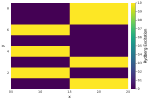

In [21]:
# snake mps starting at bottom left
geometry = "square"
N1 = 2 # x
N2 = 8 # y
# sites = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])

entropy___, energy, gs, map_ = focus(geometry, N1, N2, 4, 1.3, psi0, sites)
println(bipartite_entropy(gs))
println("Entropy: $entropy___, Energy: $energy")
println(avg_rydberg(gs))
dominant_eigenstate(gs, N1, N2)

In [20]:
rabi_freq = 1 / ((1 * 1.3)^6)
delta = 4 * rabi_freq
# sites_ = siteinds("Qubit", N1 * N2)
# psi0 = MPS(sites_, ["Up" for i = 1:N1*N2])
# psi0 = randomMPS(sites_)
entropy, energy, gs_ = ground_state(geometry, N1, N2, psi0, sites, rabi_freq, delta, false, 30)

"Rabi $(rabi_freq), Delta $(delta), Entropy $entropy, Energy $energy, Rydberg $(avg_rydberg(gs_))"
#5.84888281994566 5.8488828158414385 5.848882790439449

Variance 1.3358203432289883e-12


"Rabi 0.2071762110330033, Delta 0.8287048441320132, Entropy 0.9896877270118334, Energy -5.848882820195647, Rydberg 0.4869177786800044"

In [19]:
function get_neighbor(arr::Array{MPS,2}, x::Int, y::Int)
    # Potential neighbors' directions
    directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]

    for (dx, dy) in directions
        nx, ny = x + dx, y + dy
        if 1 <= nx <= size(arr, 1) && 1 <= ny <= size(arr, 2)
            try
                return arr[nx, ny]
            catch
                # This neighbor is uninitialized, so move on to the next one
                continue
            end
        end
    end
    return nothing
end

function stand(geometry, N1, N2, resolution, coarse, separation_assumption, start, stop, stop2, psi0, sites, ed_=true, krylov_dim=3)
    V_nn = 2 * pi * 60 * (10^6)
    V_nn = 1
    C6 = 1 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    a = 1

    freq = range(start, stop=stop, length=resolution)

    Y = freq

    X = collect(range(0.0, stop=stop2, length=resolution))

    entropies = zeros(Float64, resolution, resolution)
    numbers = zeros(Float64, resolution, resolution)
    energy_gaps = zeros(Float64, resolution, resolution)
    energies = zeros(Float64, resolution, resolution)
    second = zeros(Float64, resolution, resolution)
    hover_text = [["" for i in 1:resolution] for j in 1:resolution]

    simulation_data = Any[]

    # p = Progress(resolution^2, 1)

    ground_states = Array{MPS}(undef, resolution, resolution)
    excited_states = Array{MPS}(undef, resolution, resolution)

    for k = 1:resolution^2
        # println(threadid())
        # if threadid() == 1
        # end

        i = (k - 1) ÷ resolution + 1
        j = (k - 1) % resolution + 1

        println((i - 1) * length(X) + j)
        if ((i - 1) * resolution + j) % 5 == 0
            println((i - 1) * length(X) + j)
        end

        rabi_freq = C6 / ((a * Y[i])^6)
        delta = X[j] * rabi_freq

        psi0_candidate = get_neighbor(ground_states, i, j)
        if psi0_candidate !== nothing
            psi0 = psi0_candidate
        end

        entropy, energy, gs = ground_state(geometry, N1, N2, psi0, sites, rabi_freq, delta, ed_, krylov_dim)

        # println("Rabi $(rabi_freq), Delta $(delta), Entropy $entropy, Energy $energy, Rydberg $(avg_rydberg(gs)), Inner $(inner(gs', gs_))")
        # println(contract(gs[1])[1])

        # entropy2, energy2, gs2 = ground_state(geometry, N1, N2, MPS(sites, ["Dn" for i = 1:N1*N2]), sites, rabi_freq, delta, ed_, krylov_dim)

        # entropy3, energy3, gs3 = ground_state(geometry, N1, N2, MPS(sites, ["Dn" for i = 1:N1*N2]), sites, rabi_freq, delta, true, 30)

        # println("Inner Product State: $(inner(gs3', gs2)), Inner Superposition: $(inner(gs3', gs)), Energy Delta: $(energy - energy2), Entropy 1: $(bipartite_entropy(gs)), Entropy 2: $(bipartite_entropy(gs2))")
        # println()

        psi0_candidate = get_neighbor(excited_states, i, j)
        # if psi0_candidate !== nothing
        #     psi0 = psi0_candidate
        # end
        # energy2, s2 = first_excitation(geometry, N1, N2, psi0, gs, sites, rabi_freq, delta)

        ground_states[i, j] = gs
        # excited_states[i, j] = s2

        # push!(simulation_data, (rabi_freq, delta, entropy, energy, gs))

        entropies[i, j] = entropy
        numbers[i, j] = avg_rydberg(gs)
        # energy_gaps[i, j] = log(max(energy2 - energy, 1E-7))
        # energies[i, j] = energy

        mps_state = measure_mps(gs)
        hover_text[i][j] = join(string.(mps_state), ", ")
        # next!(p)
    end

    # compute QPT points
    # for j = 1:resolution
    #     for i = 2:resolution-1
    #         # b = (energies[i,j+1]-energies[i,j]) / (X[j+1] - X[j])
    #         # a = (energies[i, j] - energies[i, j-1]) / (X[j] - X[j-1])
    #         # hessian = abs((b - a) / (X[j+1] - X[j-1])) # not hessian
    #         # finite_diff = (2*energies[i, j] - 5*energies[i-1, j] + 4*energies[i-2, j] - energies[i-3, j]) / (Y[i] - Y[i-1])^2
    #         finite_diff = energies[i+1, j] - 2 * energies[i, j] + energies[i-1, j]
    #         finite_diff = finite_diff / (Y[i] - Y[i-1])^2
    #         second[i, j] = abs(finite_diff)
    #     end
    # end

    deltaX = (maximum(X) - minimum(X)) / length(X)
    deltaY = (maximum(Y) - minimum(Y)) / length(Y)

    # Adjust the plot limits to ensure cells are not cut off
    adjusted_xlims = (minimum(X) - 0.5 * deltaX, maximum(X) + 0.5 * deltaX)
    adjusted_ylims = (minimum(Y) - 0.5 * deltaY, maximum(Y) + 0.5 * deltaY)

    return simulation_data, psi0, heatmap(
        X, Y, energy_gaps,
        # xlims=adjusted_xlims,
        # ylims=adjusted_ylims,
        hover=hover_text,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="Δ/Ω",
        ylabel="R_b/a",
        colorbar_title="Gap ln(ε)"
    ), heatmap(
        X, Y, entropies,
        # xlims=adjusted_xlims,
        # ylims=adjusted_ylims,
        hover=hover_text,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="Δ/Ω",
        ylabel="R_b/a",
        colorbar_title="Bipartite Entropy"
    ), heatmap(
        X, Y, numbers,
        # xlims=adjusted_xlims,
        # ylims=adjusted_ylims,
        hover=hover_text,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="Δ/Ω",
        ylabel="R_b/a",
        colorbar_title="Rydberg Fraction"
    )
end

geometry = "square"
N1 = 2 # x
N2 = 8 # y
resolution = 4
coarse_resolution = 4
separation_assumption = 2
sites = siteinds("Qubit", N1 * N2)
psi0 = MPS(sites, ["Dn" for i = 1:N1*N2])
krylov_dim = 20
simulation_data1, psi0, plot1, plot2, plot3 = stand(geometry, N1, N2, resolution, coarse_resolution, separation_assumption, 0.95, 1.3, 4, psi0, sites, false, krylov_dim)
# plot_ = plot(plot1, plot2, plot3, layout=(3, 1), size=(500, 800))

1
Variance 8.995471034722868e-12
2
Variance 5.9117155615240335e-12
3
Variance 1.9554136088117957e-11
4
Variance 2.9103830456733704e-11
5
5
Variance 2.8848035071860068e-12
6
Variance 3.325340003357269e-12
7
Variance 4.121147867408581e-12
8
Variance 5.229594535194337e-12
9
Variance 1.902034085787818e-12
10
10
Variance 1.8065549056700547e-12
11
Variance 9.42890210353653e-12
12
Variance 7.23616722098086e-11
13
Variance 1.0164091790443308e-12
14
Variance 2.255529096828468e-12
15
15
Variance 2.1671553440683056e-12
16
Variance 1.3358203432289883e-12


(Any[], MPS
[1] ((dim=2|id=963|"Qubit,Site,n=1"), (dim=2|id=303|"Link,l=1"))
[2] ((dim=2|id=678|"Qubit,Site,n=2"), (dim=2|id=303|"Link,l=1"), (dim=4|id=132|"Link,l=2"))
[3] ((dim=2|id=461|"Qubit,Site,n=3"), (dim=4|id=132|"Link,l=2"), (dim=8|id=953|"Link,l=3"))
[4] ((dim=2|id=716|"Qubit,Site,n=4"), (dim=8|id=953|"Link,l=3"), (dim=16|id=230|"Link,l=4"))
[5] ((dim=2|id=339|"Qubit,Site,n=5"), (dim=16|id=230|"Link,l=4"), (dim=32|id=821|"Link,l=5"))
[6] ((dim=2|id=230|"Qubit,Site,n=6"), (dim=32|id=821|"Link,l=5"), (dim=64|id=590|"Link,l=6"))
[7] ((dim=2|id=560|"Qubit,Site,n=7"), (dim=64|id=590|"Link,l=6"), (dim=91|id=814|"Link,l=7"))
[8] ((dim=2|id=190|"Qubit,Site,n=8"), (dim=89|id=58|"Link,l=8"), (dim=91|id=814|"Link,l=7"))
[9] ((dim=2|id=542|"Qubit,Site,n=9"), (dim=84|id=585|"Link,l=9"), (dim=89|id=58|"Link,l=8"))
[10] ((dim=2|id=433|"Qubit,Site,n=10"), (dim=58|id=518|"Link,l=10"), (dim=84|id=585|"Link,l=9"))
[11] ((dim=2|id=69|"Qubit,Site,n=11"), (dim=32|id=709|"Link,l=11"), (dim=58|id=51